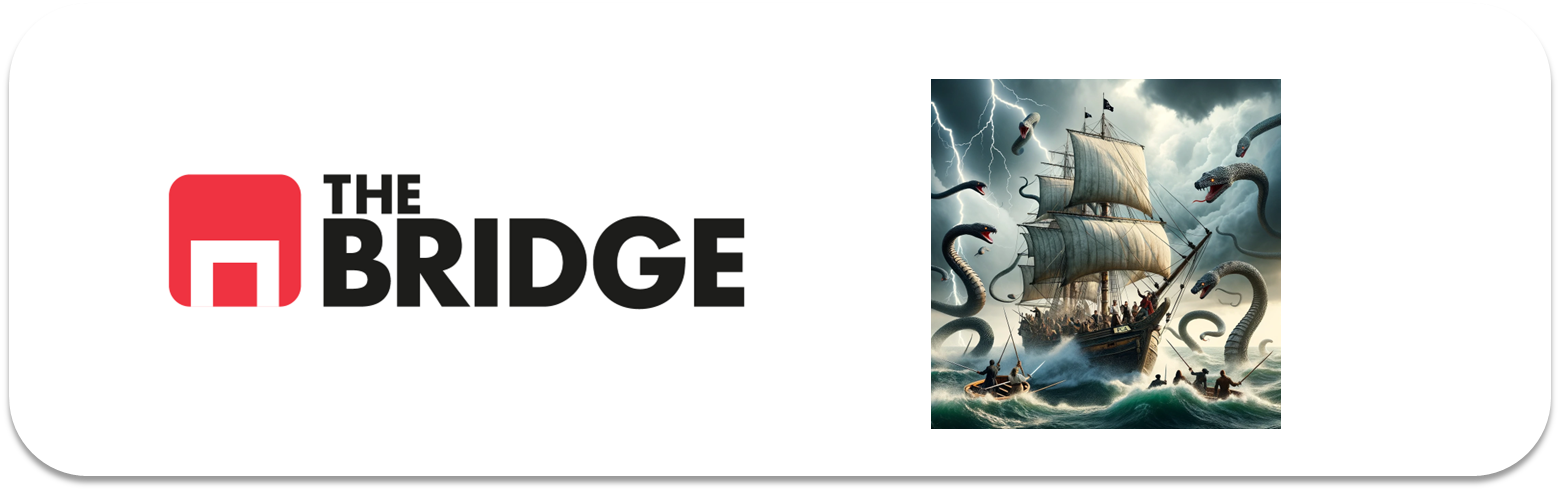

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quinientas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.copy_on_write = True # CoW por defecto a partir de pandas 3.0.0

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un dataframe con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo 
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [3]:
olivetti.images.shape

(400, 64, 64)

In [5]:
olivetti.data.shape

(400, 4096)

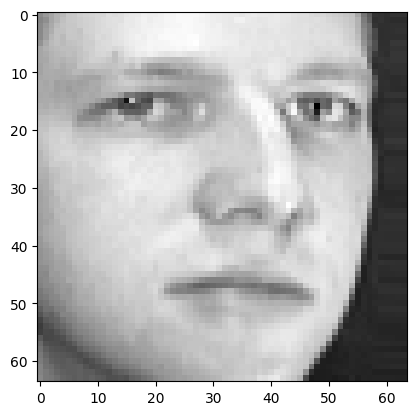

In [6]:
plt.imshow(olivetti.data[4].reshape(64,64), cmap="gray")
plt.show()

In [8]:
df = pd.DataFrame(olivetti.data, columns = [f"pixel_{i}" for i in range(olivetti.data.shape[1])])
df["face_id"] = olivetti.target

target = "face_id"
df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,face_id
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.400826,0.495868,0.570248,0.632231,0.648760,0.640496,0.661157,0.636364,0.665289,0.698347,...,0.396694,0.264463,0.099174,0.181818,0.243802,0.247934,0.161157,0.157025,0.136364,39
396,0.367769,0.367769,0.351240,0.301653,0.247934,0.247934,0.367769,0.512397,0.574380,0.628099,...,0.334711,0.289256,0.285124,0.338843,0.404959,0.458678,0.487603,0.512397,0.549587,39
397,0.500000,0.533058,0.607438,0.628099,0.657025,0.632231,0.657025,0.669421,0.673554,0.702479,...,0.148760,0.152893,0.161157,0.161157,0.173554,0.157025,0.177686,0.148760,0.190083,39
398,0.214876,0.219008,0.219008,0.223140,0.210744,0.202479,0.276859,0.400826,0.487603,0.549587,...,0.392562,0.367769,0.409091,0.479339,0.524793,0.545455,0.574380,0.590909,0.603306,39


In [10]:
df.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,face_id
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.400134,0.434236,0.476281,0.518481,0.554845,0.588729,0.621426,0.647510,0.664814,0.676591,...,0.367221,0.363027,0.355506,0.340196,0.338657,0.335909,0.321415,0.313647,0.310455,19.500000
std,0.180695,0.189504,0.194742,0.193313,0.188593,0.178481,0.167109,0.155024,0.147616,0.143583,...,0.181861,0.181611,0.188709,0.186088,0.189256,0.195280,0.187842,0.183616,0.180635,11.557853
min,0.086777,0.066116,0.090909,0.041322,0.107438,0.107438,0.115702,0.115702,0.119835,0.140496,...,0.037190,0.053719,0.049587,0.033058,0.012397,0.049587,0.057851,0.061983,0.033058,0.000000
25%,0.243802,0.267562,0.314050,0.383264,0.446281,0.515496,0.544421,0.581612,0.599174,0.611570,...,0.214876,0.219008,0.197314,0.177686,0.177686,0.173554,0.173554,0.173554,0.172521,9.750000
50%,0.392562,0.458678,0.512397,0.545455,0.584711,0.615702,0.652893,0.669421,0.683884,0.702479,...,0.367769,0.342975,0.334711,0.320248,0.314050,0.299587,0.289256,0.270661,0.272727,19.500000
75%,0.528926,0.575413,0.636364,0.666322,0.702479,0.714876,0.735537,0.757231,0.772727,0.780992,...,0.496901,0.500000,0.500000,0.479339,0.462810,0.462810,0.446281,0.414256,0.417355,29.250000
max,0.805785,0.822314,0.871901,0.892562,0.871901,0.871901,0.871901,0.871901,0.871901,0.871901,...,0.904959,0.888430,0.896694,0.826446,0.863636,0.921488,0.929752,0.884298,0.822314,39.000000


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pixel_0,400.0,0.400134,0.180695,0.086777,0.243802,0.392562,0.528926,0.805785
pixel_1,400.0,0.434236,0.189504,0.066116,0.267562,0.458678,0.575413,0.822314
pixel_2,400.0,0.476281,0.194742,0.090909,0.314050,0.512397,0.636364,0.871901
pixel_3,400.0,0.518481,0.193313,0.041322,0.383264,0.545455,0.666322,0.892562
pixel_4,400.0,0.554845,0.188593,0.107438,0.446281,0.584711,0.702479,0.871901
...,...,...,...,...,...,...,...,...
pixel_4092,400.0,0.335909,0.195280,0.049587,0.173554,0.299587,0.462810,0.921488
pixel_4093,400.0,0.321415,0.187842,0.057851,0.173554,0.289256,0.446281,0.929752
pixel_4094,400.0,0.313647,0.183616,0.061983,0.173554,0.270661,0.414256,0.884298
pixel_4095,400.0,0.310455,0.180635,0.033058,0.172521,0.272727,0.417355,0.822314


In [12]:
# Barajamos los datos

df_back = df.copy()
df = df_back.sample(len(df_back), random_state=42)
df = df.reset_index(drop=True)
df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,face_id
0,0.198347,0.235537,0.351240,0.409091,0.421488,0.429752,0.500000,0.528926,0.524793,0.553719,...,0.508264,0.524793,0.504132,0.483471,0.471074,0.285124,0.061983,0.128099,0.090909,20
1,0.185950,0.128099,0.115702,0.132231,0.185950,0.268595,0.433884,0.541322,0.570248,0.586777,...,0.396694,0.409091,0.301653,0.421488,0.462810,0.247934,0.190083,0.210744,0.210744,28
2,0.508264,0.603306,0.619835,0.628099,0.657025,0.665289,0.690083,0.727273,0.743802,0.768595,...,0.301653,0.305785,0.314050,0.326446,0.338843,0.330579,0.334711,0.342975,0.342975,3
3,0.136364,0.140496,0.185950,0.280992,0.318182,0.363636,0.409091,0.417355,0.438017,0.454545,...,0.169421,0.206612,0.276859,0.355372,0.685950,0.661157,0.280992,0.371901,0.276859,21
4,0.652893,0.644628,0.652893,0.706612,0.714876,0.719008,0.743802,0.747934,0.747934,0.756198,...,0.074380,0.074380,0.082645,0.082645,0.111570,0.070248,0.086777,0.185950,0.231405,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.194215,0.223140,0.314050,0.500000,0.636364,0.735537,0.797521,0.826446,0.847107,0.847107,...,0.206612,0.181818,0.165289,0.123967,0.123967,0.128099,0.136364,0.169421,0.165289,7
396,0.260331,0.355372,0.648760,0.822314,0.838843,0.834711,0.830579,0.826446,0.822314,0.814050,...,0.264463,0.185950,0.136364,0.177686,0.132231,0.103306,0.103306,0.107438,0.119835,10
397,0.611570,0.644628,0.657025,0.669421,0.673554,0.710744,0.735537,0.756198,0.760331,0.768595,...,0.152893,0.107438,0.119835,0.132231,0.111570,0.136364,0.177686,0.210744,0.223140,27
398,0.285124,0.293388,0.297521,0.293388,0.219008,0.107438,0.342975,0.508264,0.533058,0.557851,...,0.388430,0.442149,0.475207,0.500000,0.516529,0.520661,0.533058,0.533058,0.537190,34


In [13]:
train_set, test_set = train_test_split(df, test_size = 80, stratify = df[target], random_state = 42)

*¿Hacer miniEDA? O lo hacemos rápido o no lo hacemos, por dos razones:

1. Desde el punto de vista de la importancia o relevancia de cada feature: Son píxeles, es dedcir hacer un miniEDA para intentar entender cada uno de ellos por separado no tiene mucho sentido por lo que significa cada uno. Como mucho tiene sentido entrenar por ejemplo un random forest, y pintar las features importances de cada pixel por ver si hay alguno muy muy significativo o muy muy poco significativo.

In [14]:
X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]

X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

In [15]:
rf_clf_importancia = RandomForestClassifier(random_state = 42)
rf_clf_importancia.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
rf_clf_importancia.feature_names_in_

array(['pixel_0', 'pixel_1', 'pixel_2', ..., 'pixel_4093', 'pixel_4094',
       'pixel_4095'], dtype=object)

In [18]:
rf_clf_importancia.feature_importances_.cumsum()

array([1.12443026e-04, 2.89824574e-04, 5.53473645e-04, ...,
       9.98365863e-01, 9.99413019e-01, 1.00000000e+00])

In [19]:
len(rf_clf_importancia.feature_importances_)

4096

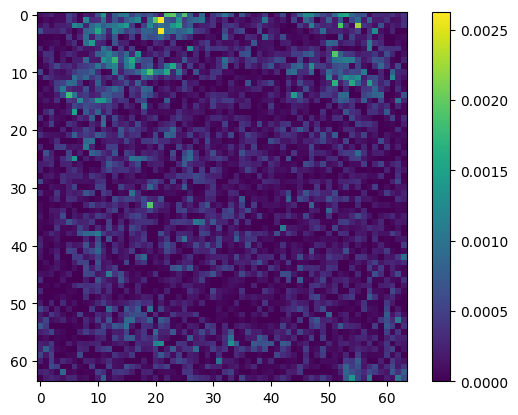

In [20]:
imagen_importancia = rf_clf_importancia.feature_importances_.reshape(64,64)
plt.imshow(imagen_importancia)
plt.colorbar()

*Se ven algunos que destacan un poco más pero dentro de unos rangos de importancia pequeñísimos, hacer aquí selección con criterio es difícil.  
La ventaja de la PCA es que cada componente principal se lleva algo de cada pixel.*

In [19]:
pd.Series(rf_clf_importancia.feature_importances_).describe()

count    4096.000000
mean        0.000244
std         0.000283
min         0.000000
25%         0.000032
50%         0.000168
75%         0.000349
max         0.002628
dtype: float64

2. Del lado de detectar necesidad de escalado de algún pixel:

In [20]:
X_train.describe().T["max"] - X_train.describe().T["min"]

pixel_0       0.719008
pixel_1       0.756198
pixel_2       0.743802
pixel_3       0.814050
pixel_4       0.752066
                ...   
pixel_4091    0.772727
pixel_4092    0.871901
pixel_4093    0.867769
pixel_4094    0.822314
pixel_4095    0.789256
Length: 4096, dtype: float64

In [22]:
df_describe = X_train.describe().T
df_describe

,count,mean,std,min,25%,50%,75%,max
pixel_0,320.0,0.399716,0.177370,0.086777,0.251033,0.388430,0.528926,0.805785
pixel_1,320.0,0.430436,0.187762,0.066116,0.264463,0.454545,0.574380,0.822314
pixel_2,320.0,0.469576,0.193995,0.090909,0.301653,0.504132,0.633264,0.834711
pixel_3,320.0,0.512590,0.191925,0.041322,0.376033,0.545455,0.661157,0.855372
pixel_4,320.0,0.550465,0.188693,0.107438,0.445248,0.578512,0.685950,0.859504
...,...,...,...,...,...,...,...,...
pixel_4091,320.0,0.335615,0.190127,0.012397,0.173554,0.299587,0.463843,0.785124
pixel_4092,320.0,0.332438,0.195619,0.049587,0.173554,0.293388,0.459711,0.921488
pixel_4093,320.0,0.317045,0.187476,0.061983,0.173554,0.278926,0.431818,0.929752
pixel_4094,320.0,0.309452,0.183148,0.061983,0.173554,0.256198,0.409091,0.884298


count    4096.000000
mean        0.693583
std         0.097013
min         0.396694
25%         0.640496
50%         0.706612
75%         0.756198
max         0.938017
Name: rango, dtype: float64


<Axes: xlabel='rango', ylabel='Count'>

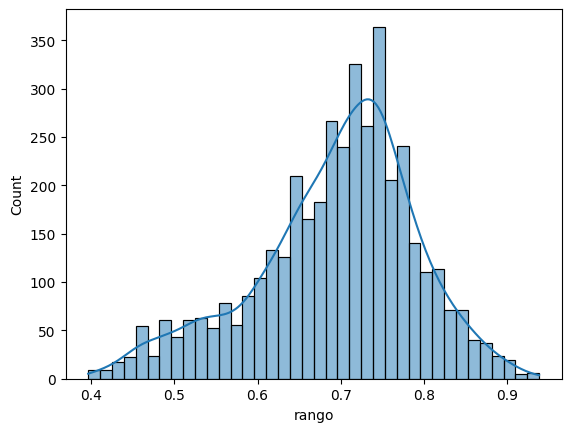

In [23]:
df_describe["rango"] = df_describe["max"] - df_describe["min"]
print(df_describe["rango"].describe())
sns.histplot(df_describe["rango"], kde = True)

<Axes: ylabel='rango'>

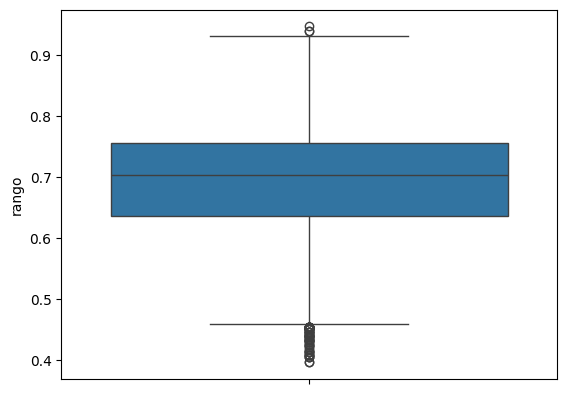

In [19]:
sns.boxplot(df_describe["rango"])

*Los rangos están contenidos entre 0.4 y 0.9 con el 50% de ellos entre 0.63 y 0.75, y la desviación estandar es de 0.09, en definitiva los rangos son muy parecidos, con lo que no parece necesario escalar nada*

*Lo bueno es que ya hemos entrenado el modelo baseline para obtener su valor de precisión frente a test*


In [24]:
y_pred = rf_clf_importancia.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       0.67    

In [25]:
# esta es la forma de obtener el recall medio sin copiarlo a ojo
baseline_test = recall_score(y_test, y_pred, average = "macro")
baseline_test


0.95

In [26]:
baseline_cv = np.mean(cross_val_score(rf_clf_importancia, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
baseline_cv

0.9325000000000001

In [27]:
# Redondeamos un poquito el baseline

baseline_cv = round(baseline_cv, 3)
baseline_cv

0.933

*El hecho de haber obtenido mejor rendimiento en test que en cross_validation nos "congratula", pero hay que ser un poco pesimistas en esto del datascience. Es más probable que en la realidad nuestro modelo se acerque más al resultado de la validación cruzada que al del test. Contemos siempre con el valor más bajo de los dos*

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [28]:
X_train.shape

(320, 4096)

In [28]:
pca = PCA() # num entero -> num. de PCs, si float entre 0 y 1 -> el número de PCs para conseguir al menos esa varianza acumulada
pca.fit(X_train)

PCA()

In [29]:
X_train.shape

(320, 4096)

*Cabría esperar que nuestra pca sin argumentos tuviera tantas componentes como features el train, ya que no le hemos puesto restricción y la PCA siempre obtiene tantas componentes principales como features, pero en sklearn...*

In [30]:
len(X_train)

320

In [31]:
pca.n_components_ # num_features >> num_instancias tiene muy alta dimensionalidad,  PCA > num_instancias

320

*Hmmm, ¿Qué ha pasado aquí?... Si miras la documentación del constructor de PCA lo entenderas (cuando el dataset tiene una alta dimensionalidad n_features > num_instancias, sklearn sólo obtiene tantas PCs como instancias)*

*Nos vale, porque si vemos la varianza acumulada:*

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.24218807, 0.3826843 , 0.46095803, 0.5113758 , 0.54622835,
       0.579085  , 0.6038183 , 0.62378263, 0.64356625, 0.6602359 ,
       0.67521125, 0.689301  , 0.7023266 , 0.7138658 , 0.7245692 ,
       0.73437303, 0.74383384, 0.7523936 , 0.76029515, 0.76775944,
       0.7747295 , 0.7813285 , 0.78730863, 0.79307646, 0.7984634 ,
       0.8037794 , 0.808892  , 0.8135358 , 0.8181741 , 0.82252806,
       0.8265747 , 0.8304535 , 0.8341706 , 0.8375936 , 0.84090364,
       0.84412307, 0.84722865, 0.8501936 , 0.85311764, 0.855931  ,
       0.8586057 , 0.86119306, 0.8636692 , 0.8660439 , 0.8683779 ,
       0.8706829 , 0.87292796, 0.87512195, 0.877259  , 0.879366  ,
       0.8813918 , 0.8834015 , 0.88533646, 0.8872298 , 0.8890926 ,
       0.89089316, 0.8926366 , 0.89436316, 0.8960343 , 0.8976367 ,
       0.8992061 , 0.90076566, 0.9023083 , 0.9038201 , 0.9052813 ,
       0.90673393, 0.9081569 , 0.9095601 , 0.9109373 , 0.912279  ,
       0.9136158 , 0.9149193 , 0.91619873, 0.9174257 , 0.91864

*Con las 320 PCs la acumula toda*

Ahora vamos a ver las pcs necesarias para 10 valores entre 0.2% y 2.5% de compresión

In [34]:
# 0.2% 
# num_pcs / num_total_features = rango

num_features = len(X_train.columns) # Si son 4096, por florear un poco
num_pcs = 0.2 * num_features / 100
num_pcs

8.192

In [35]:
X_train.to_csv("prueba.csv")
X_train.iloc[:,0:8].to_csv("prueba_comprimida.csv")

In [35]:
# Para 0.2% compresión -> cuántas pcs necesito, 4096 de partida 0.2,0.5,1,2
num_pca = 0.2/ 100 * 4096
num_pca

8.192

In [37]:
# Los rangos que voy a probar
np.linspace(0.2, 2.5, 5)

array([0.2  , 0.775, 1.35 , 1.925, 2.5  ])

In [38]:
compresion_maxima = 0.2
compresion_minima = 2.5

num_pcs = []
num_features = len(X_train.columns) # Sí, son 4096, por florear un poco

for rango in np.linspace(compresion_maxima, compresion_minima, 5):
    # grado compresion = num_pc/num_features * 100 -> num_pc = grado_compresion * num_features / 100
    num_pc = int(rango * num_features / 100)
    print(f"Para {rango:0.3f}% de compresión, voy a probar {num_pc} PCs")
    num_pcs.append(num_pc)
print("Rangos que voy a probar:")
print(num_pcs)

Para 0.200% de compresión, voy a probar 8 PCs
Para 0.775% de compresión, voy a probar 31 PCs
Para 1.350% de compresión, voy a probar 55 PCs
Para 1.925% de compresión, voy a probar 78 PCs
Para 2.500% de compresión, voy a probar 102 PCs
Rangos que voy a probar:
[8, 31, 55, 78, 102]


In [39]:
X_train_pca = pca.transform(X_train) # Devuelve un array de numpy
X_test_pca = pca.transform(X_test) # Con la misma proyección del train, no volvemos a fitear a test

X_train_pca.shape

(320, 320)

In [44]:
X_test_pca.shape

(80, 320)

In [36]:
num_pcs

[8, 31, 55, 78, 102]

In [40]:
pd.DataFrame(X_train_pca[:,:102])

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.526413,2.222135,1.068338,-1.799263,-0.718517,1.524716,1.440423,-2.113126,1.996855,-0.587921,...,0.409694,0.364424,0.127858,0.152414,-0.046936,0.212169,-0.025341,-0.167164,0.013212,0.045458
1,4.355064,2.870463,-0.259196,2.451993,3.452964,-1.514535,1.363052,0.492711,-0.245776,0.741321,...,0.058027,-0.050006,-0.047627,0.094173,0.195839,0.436121,-0.076451,0.085244,-0.106784,-0.023862
2,4.598118,-0.380961,-0.637662,-0.296071,-0.376375,0.982532,0.795213,-0.804212,-0.506526,0.792182,...,0.004496,-0.137864,-0.322160,0.134777,0.102663,0.156332,0.187861,-0.128681,0.138752,-0.130767
3,-0.847229,-0.746168,-0.085557,-0.634096,0.677877,2.146520,1.798242,-1.140497,1.234232,-0.076508,...,0.529202,-0.451490,0.196262,-0.517808,0.134980,-0.117779,-0.181792,0.075991,-0.600426,-0.199799
4,3.364861,3.805041,-2.646904,-2.462325,-1.136394,1.312314,-0.373386,-1.876120,-1.871610,0.409607,...,-0.281805,0.011969,-0.354317,-0.401695,0.377135,0.086455,0.264721,-0.181751,-0.140019,-0.075838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-4.455236,1.958485,-2.402827,0.615186,-1.063919,0.293739,1.641575,1.163062,-2.407105,2.074335,...,0.452213,-0.238107,0.335806,0.014074,-0.082715,0.133876,0.217918,0.280674,-0.023609,-0.338334
316,0.224621,2.349910,-0.540400,-3.880446,-0.088332,2.083120,1.070109,1.195135,-3.036243,-0.982557,...,0.141631,-0.489409,0.297195,-0.221701,0.621765,-0.388040,-0.227873,-0.038089,-0.405376,0.559470
317,-10.044880,-0.453791,-0.332879,0.322786,-0.293149,-1.408972,-0.135375,1.448619,-1.582181,0.459674,...,0.681284,0.248386,-0.062071,0.283905,0.219279,0.099944,0.095599,-0.576293,-0.199370,0.378824
318,-2.732204,2.213702,2.782176,-0.212004,1.319136,0.554618,0.233085,1.624686,-1.813933,-1.339303,...,-0.038325,-0.090954,0.065294,-0.249440,-0.140015,0.054365,-0.072336,0.266531,-0.117418,0.141378


In [40]:
pca.explained_variance_ratio_.cumsum()[:102]

array([0.24218807, 0.3826843 , 0.46095803, 0.5113758 , 0.54622835,
       0.579085  , 0.6038183 , 0.62378263, 0.64356625, 0.6602359 ,
       0.67521125, 0.689301  , 0.7023266 , 0.7138658 , 0.7245692 ,
       0.73437303, 0.74383384, 0.7523936 , 0.76029515, 0.76775944,
       0.7747295 , 0.7813285 , 0.78730863, 0.79307646, 0.7984634 ,
       0.8037794 , 0.808892  , 0.8135358 , 0.8181741 , 0.82252806,
       0.8265747 , 0.8304535 , 0.8341706 , 0.8375936 , 0.84090364,
       0.84412307, 0.84722865, 0.8501936 , 0.85311764, 0.855931  ,
       0.8586057 , 0.86119306, 0.8636692 , 0.8660439 , 0.8683779 ,
       0.8706829 , 0.87292796, 0.87512195, 0.877259  , 0.879366  ,
       0.8813918 , 0.8834015 , 0.88533646, 0.8872298 , 0.8890926 ,
       0.89089316, 0.8926366 , 0.89436316, 0.8960343 , 0.8976367 ,
       0.8992061 , 0.90076566, 0.9023083 , 0.9038201 , 0.9052813 ,
       0.90673393, 0.9081569 , 0.9095601 , 0.9109373 , 0.912279  ,
       0.9136158 , 0.9149193 , 0.91619873, 0.9174257 , 0.91864

In [45]:
num_pcs

[8, 31, 55, 78, 102]

In [41]:
lista_valores = []

for num_pc in num_pcs:
    X_train_temp = X_train_pca[:,:num_pc] # 
    X_test_temp = X_test_pca[:, :num_pc]

    rf_clf = RandomForestClassifier(random_state = 42)
    eval_cv = np.mean(cross_val_score(rf_clf, X_train_temp, y_train, cv = 5, scoring = "balanced_accuracy"))

    rf_clf.fit(X_train_temp, y_train)
    y_pred = rf_clf.predict(X_test_temp)
    
    eval_test = recall_score(y_test, y_pred, average = "macro")

    datos = {
        "num_pc": num_pc,
        "factor_compresión": round(num_pc/num_features*100,3),
        "eval_cv": round(eval_cv * 100,3),
        "baseline_cv": round(baseline_cv * 100,3),
        "diff_cv": round((baseline_cv - eval_cv) * 100,3),
        "eval_test": round(eval_test * 100,3),
        "baseline_test": round(baseline_test * 100,3),
        "diff_test": round((baseline_test - eval_test) * 100,3),
    }
    
    lista_valores.append(datos.copy())


In [42]:
lista_valores

[{'num_pc': 8,
  'factor_compresión': 0.195,
  'eval_cv': 78.75,
  'baseline_cv': 93.3,
  'diff_cv': 14.55,
  'eval_test': 83.75,
  'baseline_test': 95.0,
  'diff_test': 11.25},
 {'num_pc': 31,
  'factor_compresión': 0.757,
  'eval_cv': 90.75,
  'baseline_cv': 93.3,
  'diff_cv': 2.55,
  'eval_test': 91.25,
  'baseline_test': 95.0,
  'diff_test': 3.75},
 {'num_pc': 55,
  'factor_compresión': 1.343,
  'eval_cv': 91.5,
  'baseline_cv': 93.3,
  'diff_cv': 1.8,
  'eval_test': 95.0,
  'baseline_test': 95.0,
  'diff_test': 0.0},
 {'num_pc': 78,
  'factor_compresión': 1.904,
  'eval_cv': 89.75,
  'baseline_cv': 93.3,
  'diff_cv': 3.55,
  'eval_test': 95.0,
  'baseline_test': 95.0,
  'diff_test': 0.0},
 {'num_pc': 102,
  'factor_compresión': 2.49,
  'eval_cv': 90.25,
  'baseline_cv': 93.3,
  'diff_cv': 3.05,
  'eval_test': 96.25,
  'baseline_test': 95.0,
  'diff_test': -1.25}]

In [43]:
df_resultados = pd.DataFrame(lista_valores)
df_resultados

,num_pc,factor_compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
0,8,0.195,78.75,93.3,14.55,83.75,95.0,11.25
1,31,0.757,90.75,93.3,2.55,91.25,95.0,3.75
2,55,1.343,91.50,93.3,1.80,95.00,95.0,0.00
3,78,1.904,89.75,93.3,3.55,95.00,95.0,0.00
4,102,2.490,90.25,93.3,3.05,96.25,95.0,-1.25


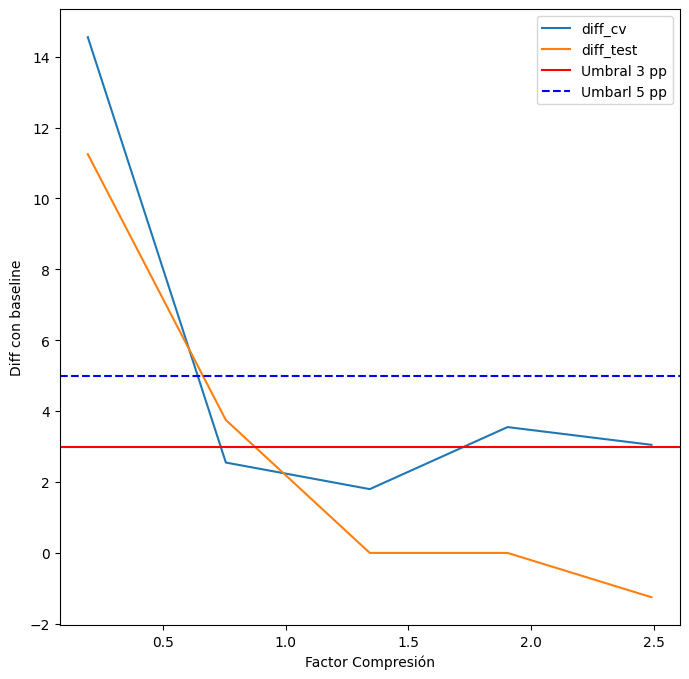

In [44]:
plt.figure(figsize=(8,8))
umbral_corte_1 = 3
umbral_corte_2 = 5

for lineas in ["diff_cv","diff_test"]:
    plt.plot(df_resultados["factor_compresión"], df_resultados[lineas], label = lineas)
plt.xlabel("Factor Compresión")
plt.ylabel("Diff con baseline")
plt.axhline(y = umbral_corte_1, color = 'r', linestyle = '-', label = f"Umbral {umbral_corte_1} pp")
plt.axhline(y = umbral_corte_2, color = "b", linestyle = "--",label = f"Umbarl {umbral_corte_2} pp")

plt.legend()
plt.show()

*Dado el enunciado tenemos varios posibles factores (y por tanto número de PCAs para elegir):*

In [45]:
cumple_umbral_1 = (df_resultados["diff_cv"] <= umbral_corte_1) | (df_resultados["diff_test"] <= umbral_corte_1)
df_resultados[cumple_umbral_1]

,num_pc,factor_compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
1,31,0.757,90.75,93.3,2.55,91.25,95.0,3.75
2,55,1.343,91.50,93.3,1.80,95.00,95.0,0.00
3,78,1.904,89.75,93.3,3.55,95.00,95.0,0.00
4,102,2.490,90.25,93.3,3.05,96.25,95.0,-1.25


*Me quedaría con 31 componentes principales que es la de mayor compresión (por debajo del 1%), además es la de menor diferencia en test junto con 55 PC*

### #EXTRA: Veamos el impacto de las 2 primeras PCs



1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)


In [45]:
df_extra = pd.DataFrame(X_train_pca[:,:2], columns = ["PC_1","PC_2"])
df_extra["target"] = y_train.values # Si no pones values intenta asignar por indices y como no coinciden crea nulos


In [46]:
df_extra_t1 = df_extra[df_extra.target.isin(range(10))]
df_extra_t2 = df_extra[df_extra.target.isin(range(10,20))]
df_extra_t3 = df_extra[df_extra.target.isin(range(20,30))]
df_extra_t4 = df_extra[df_extra.target.isin(range(30,40))]


<Axes: xlabel='PC_1', ylabel='PC_2'>

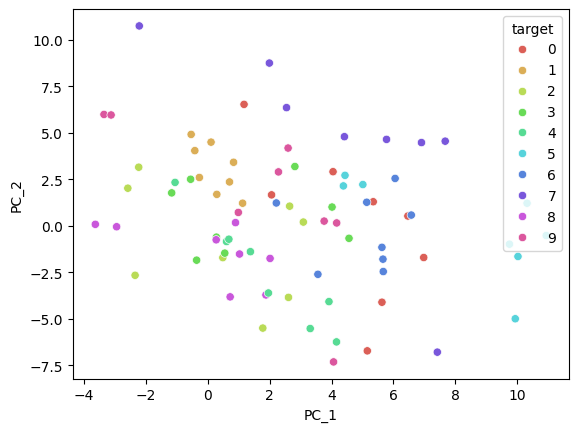

In [47]:
# Mucho cuidado con los cmaps o palettes, si usas "viridis" el scatterplot no será capaz de representar todas las clases

sns.scatterplot(data = df_extra_t1, x = "PC_1", y = "PC_2", hue = "target", palette = sns.color_palette("hls", 10))


<Axes: xlabel='PC_1', ylabel='PC_2'>

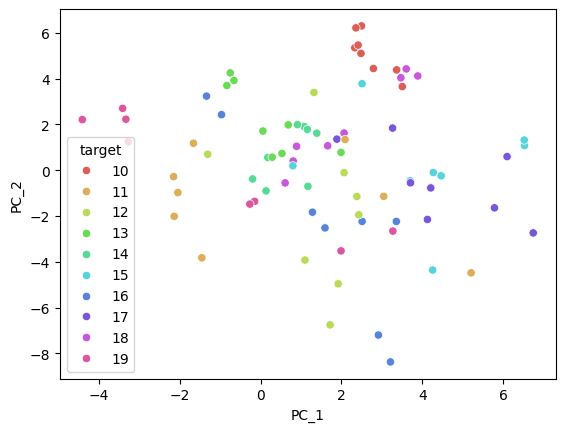

In [48]:
sns.scatterplot(data = df_extra_t2, x = "PC_1", y = "PC_2", hue = "target", palette = sns.color_palette("hls", 10))


<Axes: xlabel='PC_1', ylabel='PC_2'>

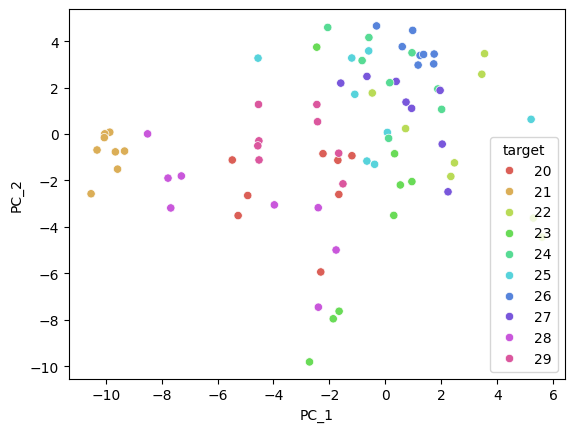

In [49]:
sns.scatterplot(data = df_extra_t3, x = "PC_1", y = "PC_2", hue = "target", palette = sns.color_palette("hls", 10))


<Axes: xlabel='PC_1', ylabel='PC_2'>

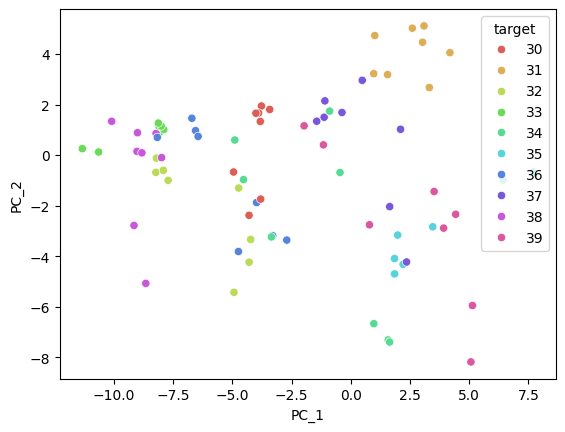

In [50]:
sns.scatterplot(data = df_extra_t4, x = "PC_1", y = "PC_2", hue = "target", palette = sns.color_palette("hls", 10))


In [51]:
pca.explained_variance_ratio_[0:2].cumsum()


array([0.2381332 , 0.36946243], dtype=float32)

*Con las dos primeras componentes solo explicamos un 37% de la varianza del conjunto de caras y no es suficiente para ver clusteres o separaciones claras en las gráficas de comparación de ambas, por lo que este enfoque no resulta útil como en otros datasets :-(*

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [46]:
np.linspace(0.1, 1, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [48]:
compresion_maxima = 0.1
compresion_minima = 1

num_pcs = []
num_features = len(X_train.columns) # Si son 4096, por florear un poco

for rango in np.linspace(compresion_maxima, compresion_minima, 5):
    # grado compresion = num_pc/num_features * 100 -> num_pc = grado_compresion * num_features / 100
    num_pc = int(rango * num_features/100)
    num_pcs.append(num_pc)
    
print("Rangos que voy a probar:")
print(num_pcs)

Rangos que voy a probar:
[4, 13, 22, 31, 40]


In [49]:
lista_valores = []

for num_pc in num_pcs:
    pca_temp = PCA(num_pc) # Por una cuestión de funcionamiento de la clase PCA tenemos que "comprimir" de nuevo no podemos usar el X_train_pca directamente
    X = pca_temp.fit_transform(X_train)
    X_t = pca_temp.transform(X_test)
    
    X_train_temp = pca_temp.inverse_transform(X) # AQUI ESTA LA CLAVE, primero nos quedamos con el dataset pequeño y luego "descomprimimos"
    print("num pcas:", num_pc, "num features descomprimdas: ", X_train_temp.shape[1])
    X_test_temp = pca_temp.inverse_transform(X_t) # APLICAMOS lo mismo a test

    rf_clf = RandomForestClassifier(random_state = 42)
    eval_cv = np.mean(cross_val_score(rf_clf, X_train_temp, y_train, cv = 5, scoring = "balanced_accuracy"))

    rf_clf.fit(X_train_temp, y_train)
    y_pred = rf_clf.predict(X_test_temp)
    eval_test = recall_score(y_test, y_pred, average = "macro")

    datos = {
        "num_pc": num_pc,
        "factor_compresión": round(num_pc/num_features*100,2),
        "eval_cv": round(eval_cv * 100,2),
        "baseline_cv": round(baseline_cv * 100,2),
        "diff_cv": round((baseline_cv - eval_cv) * 100,2),
        "eval_test": round(eval_test * 100,2),
        "baseline_test": round(baseline_test * 100,2),
        "diff_test": round((baseline_test - eval_test) * 100,2),
    }
    
    lista_valores.append(datos.copy())


num pcas: 4 num features descomprimdas:  4096
num pcas: 13 num features descomprimdas:  4096
num pcas: 22 num features descomprimdas:  4096
num pcas: 31 num features descomprimdas:  4096
num pcas: 40 num features descomprimdas:  4096


In [50]:
df_resultados = pd.DataFrame(lista_valores)
df_resultados

,num_pc,factor_compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
0,4,0.10,62.25,93.3,31.05,65.00,95.0,30.00
1,13,0.32,86.00,93.3,7.30,92.50,95.0,2.50
2,22,0.54,90.25,93.3,3.05,88.75,95.0,6.25
3,31,0.76,90.00,93.3,3.30,92.50,95.0,2.50
4,40,0.98,91.25,93.3,2.05,91.25,95.0,3.75


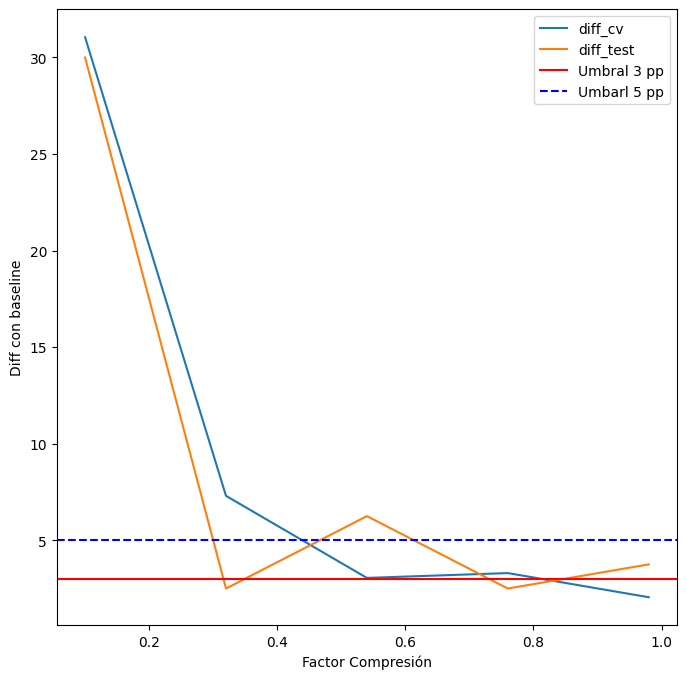

In [51]:
plt.figure(figsize=(8,8))
umbral_corte_1 = 3
umbral_corte_2 = 5

for lineas in ["diff_cv","diff_test"]:
    plt.plot(df_resultados["factor_compresión"], df_resultados[lineas], label = lineas)
plt.xlabel("Factor Compresión")
plt.ylabel("Diff con baseline")
plt.axhline(y = umbral_corte_1, color = 'r', linestyle = '-', label = f"Umbral {umbral_corte_1} pp")
plt.axhline(y = umbral_corte_2, color = "b", linestyle = "--",label = f"Umbarl {umbral_corte_2} pp")

plt.legend()
plt.show()

In [54]:
cumple_umbral_1 = (df_resultados["diff_cv"] <= 3) | (df_resultados["diff_test"] <= 5)
df_resultados[cumple_umbral_1]

,num_pc,factor_compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
1,13,0.32,86.00,93.3,7.30,92.50,95.0,2.50
3,31,0.76,90.00,93.3,3.30,92.50,95.0,2.50
4,40,0.98,91.25,93.3,2.05,91.25,95.0,3.75


*Las configuraciones de 31 y 40 pc cumplen con lo que se pide en el enunciado. Deberíamos probar con 31 (y probar 40 pc en el caso anterior) para comprobar que pudieramos tener una o dos soluciones únicas para las dos modalidades y que los directores del Caesar Palace pudieran decidir cuando activar una u otra sin necesidad de tocar los modelos internos de las minicámaras*

### #EXTRA


2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 320 PCs para que se vea que son las mismas claras con claridad.

*Aprovechando la función de la práctica obligatoria de las caras del sprint anterior, unidad 1, vamos a visualizar qué ocurre cuando comprimimos y descomprimos nuestros datos con PCA, de forma que entendamos a qué nos referimos cuando hablamos de perder información/varianza*

In [55]:
def pinta_caras(faces,n_cols = 5, title = ""):
    faces = faces.reshape(-1, 64, 64)
    n_rows = ((len(faces) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 4, n_rows * 4.4))
    for index, face in enumerate(faces):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
    plt.title(title)
    plt.show()


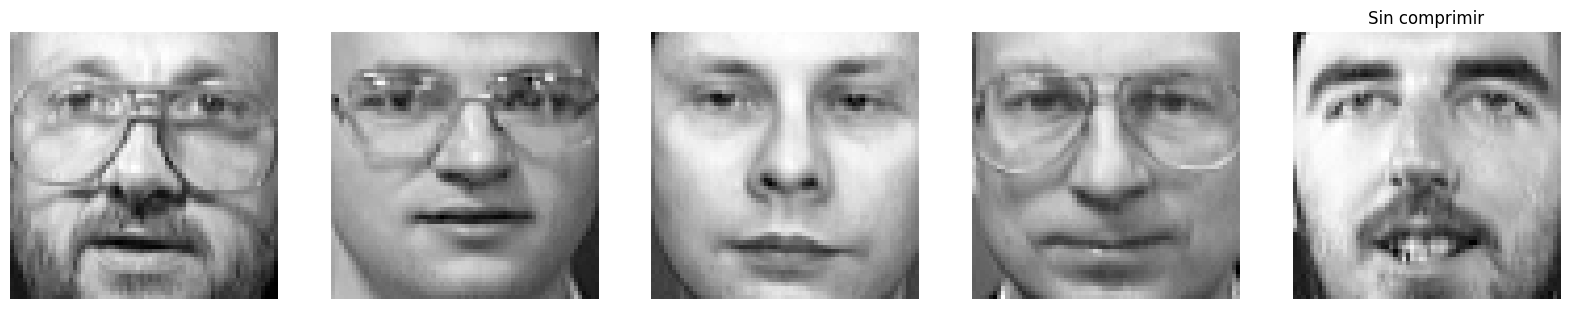

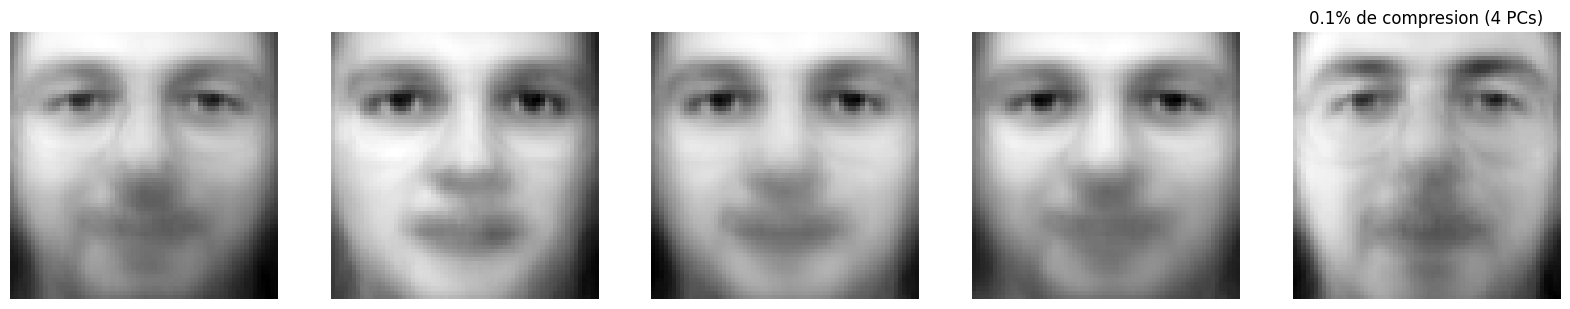

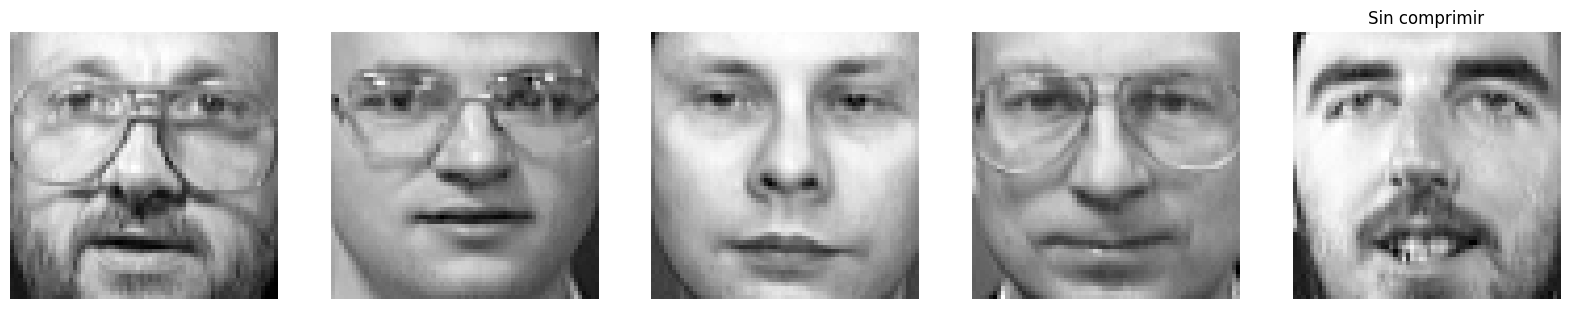

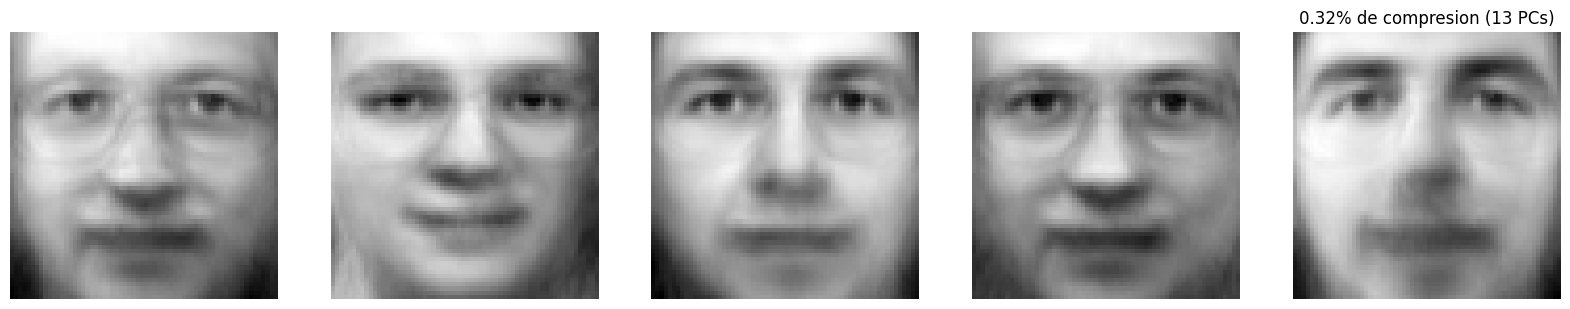

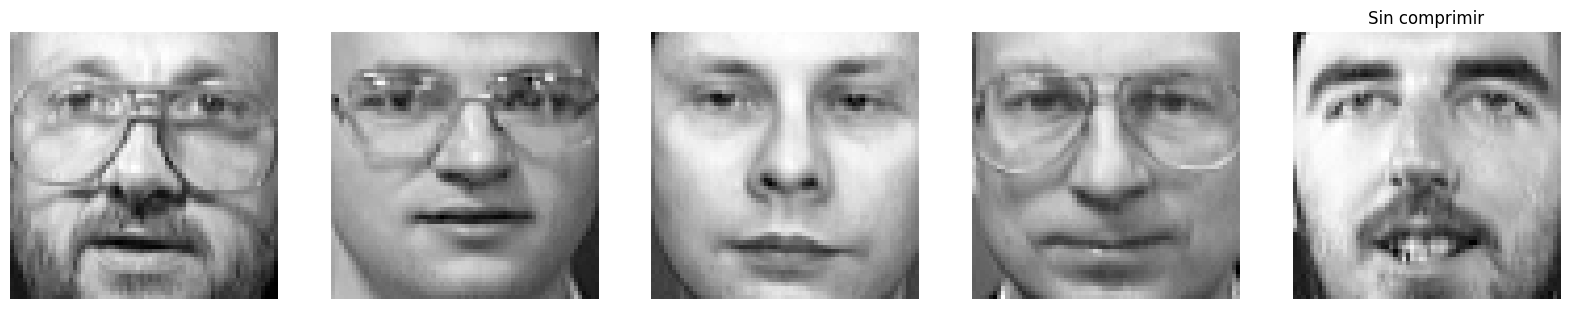

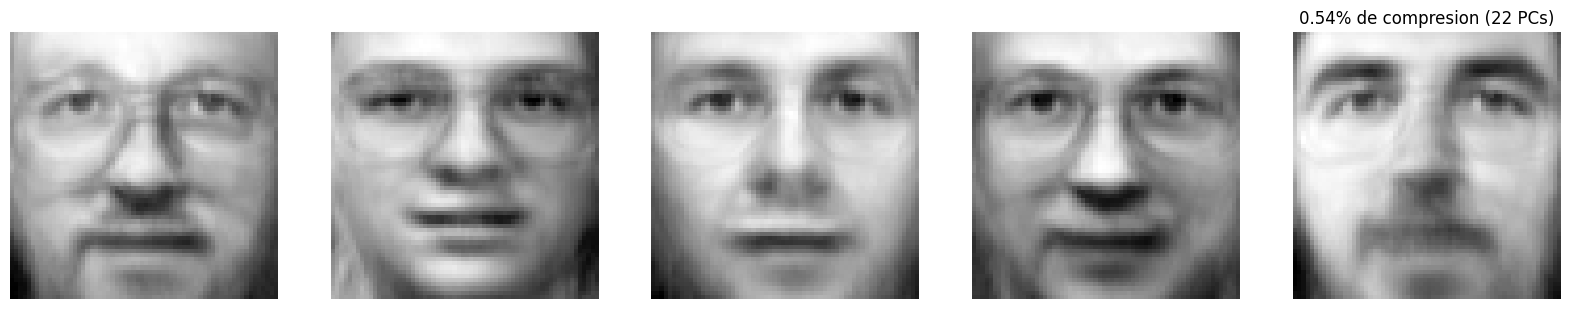

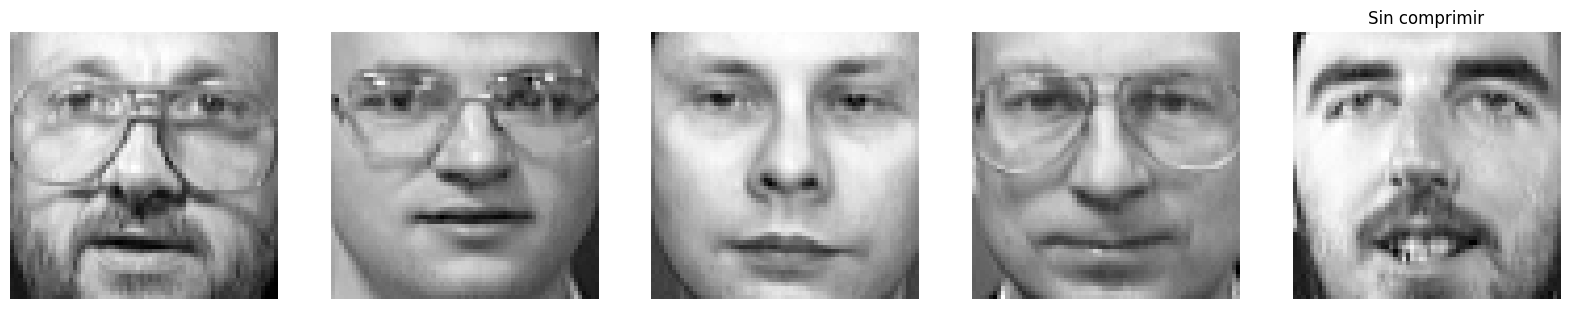

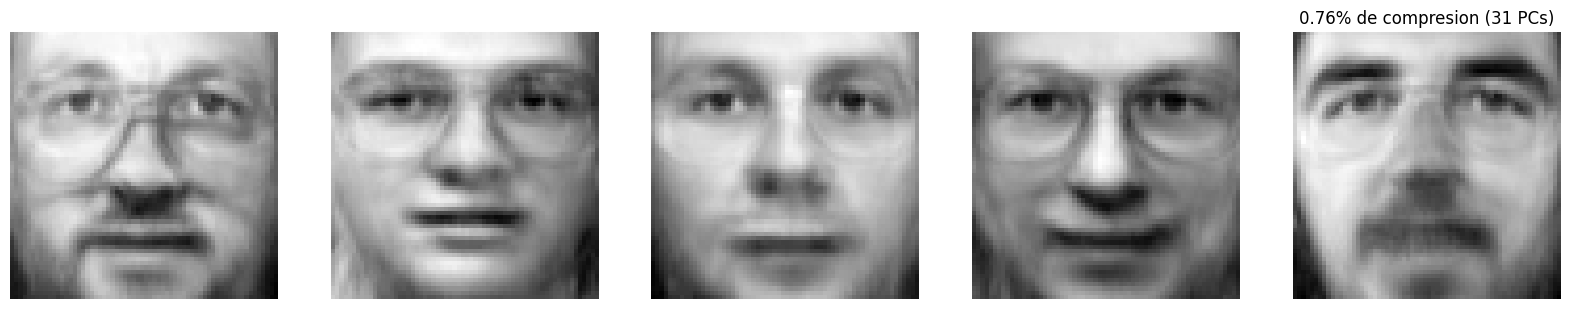

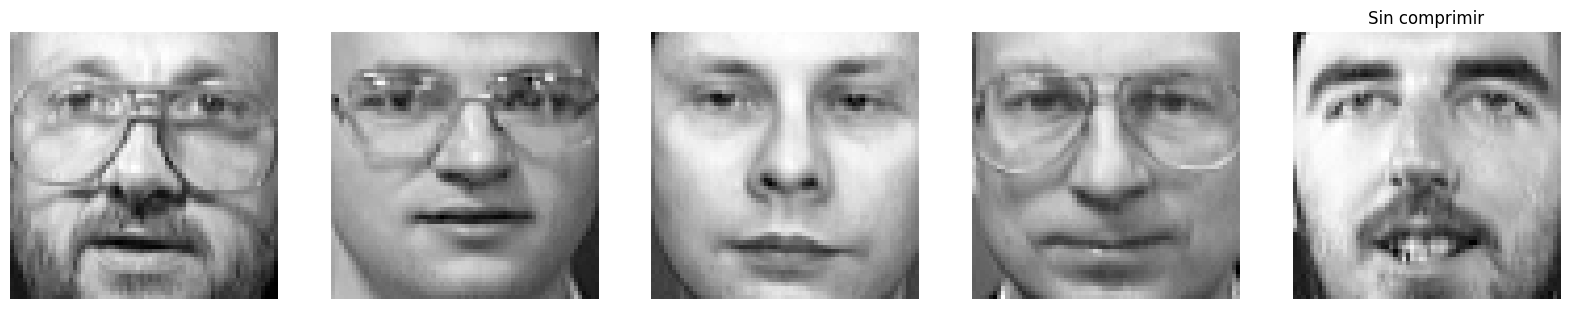

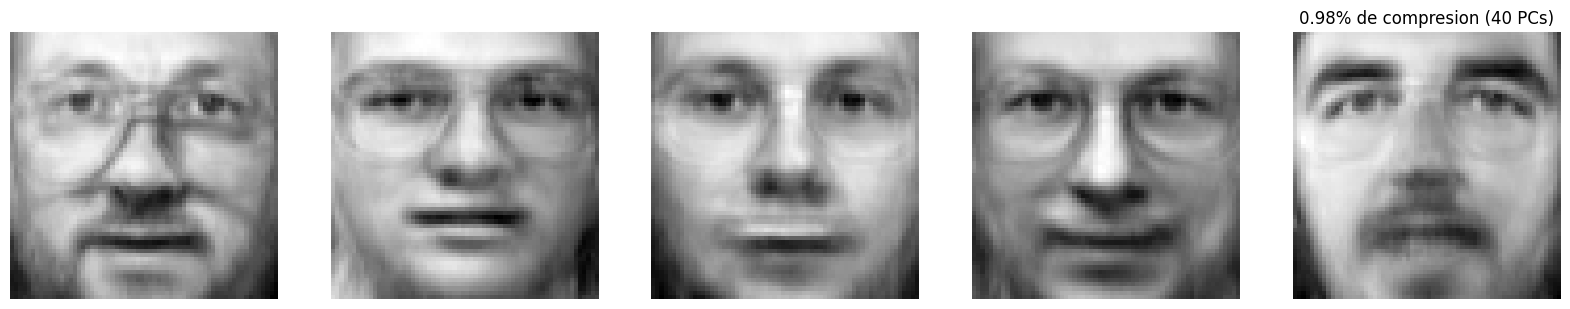

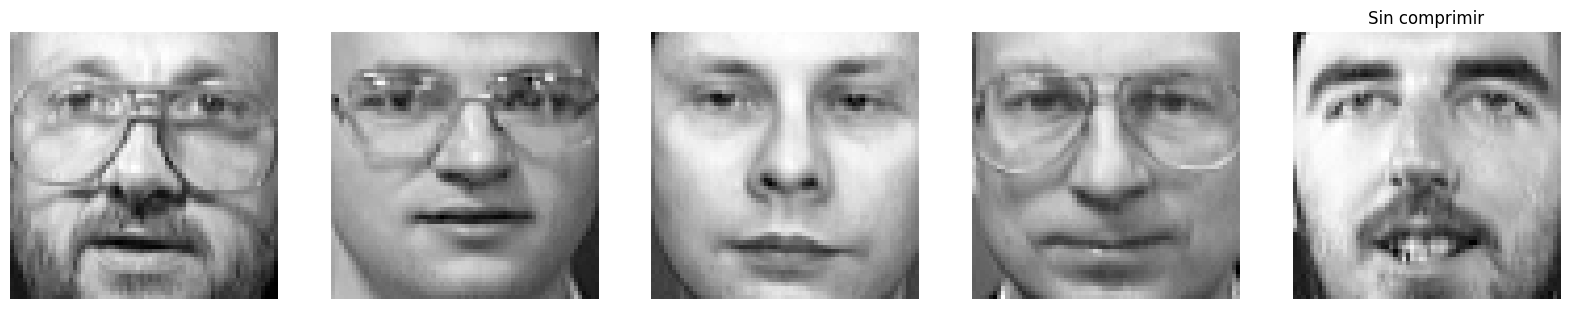

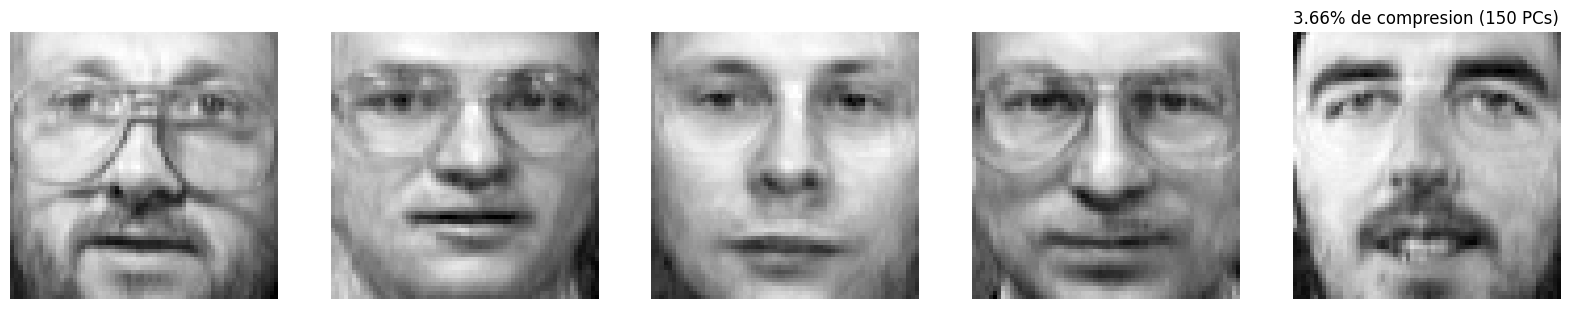

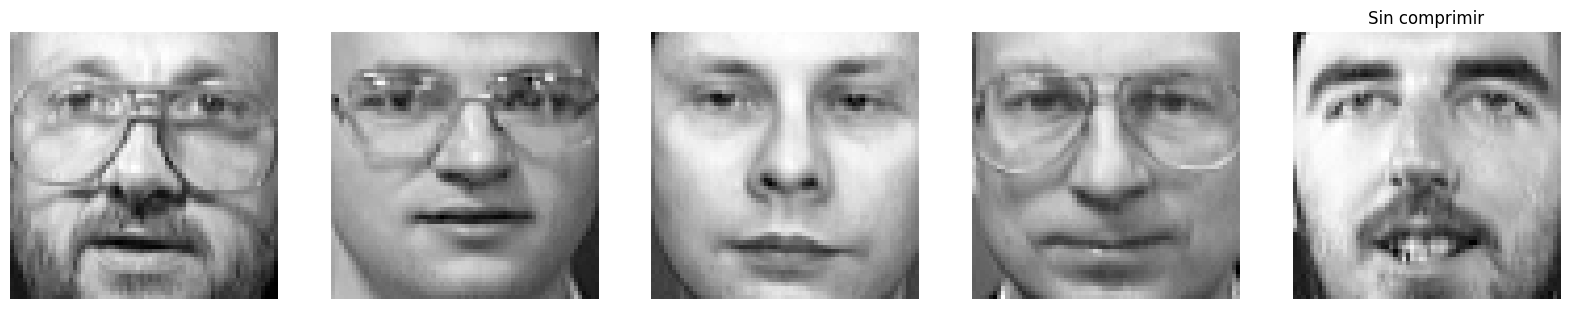

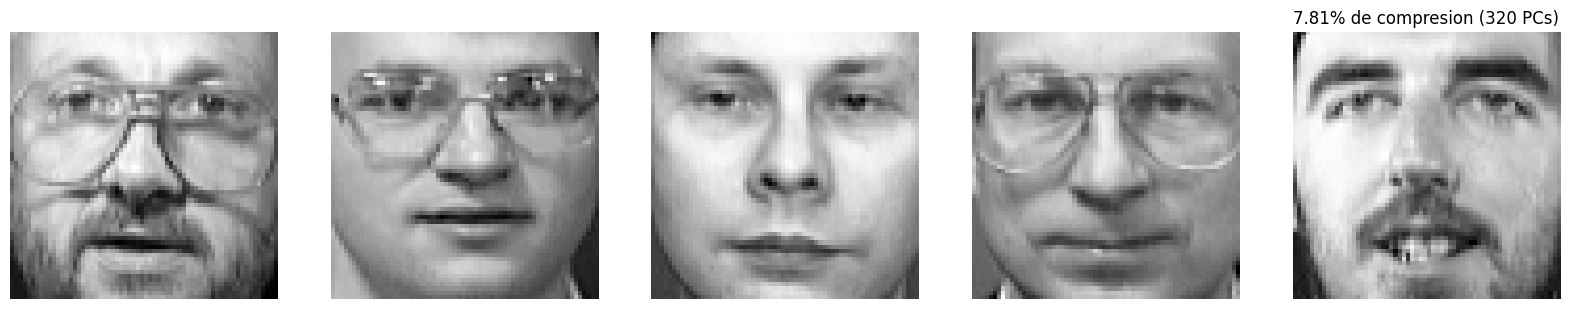

In [56]:
for num_pc in num_pcs + [150,320]: # Añdimos 2 más para que se vea que son las mismas caras :-D
    pca_temp = PCA(num_pc) # Por una cuestión de funcionamiento de la clase PCA tenemos que "comprimir" de nuevo no podemos usar el X_train_pca directamente
    X = pca_temp.fit_transform(X_train)
    X_train_temp = pca_temp.inverse_transform(X) # AQUI ESTA LA CLAVE, primero nos quedamos con el dataset pequeño y luego "descomprimimos"
    pinta_caras(X_train[0:5].values, title = "Sin comprimir")
    pinta_caras(X_train_temp[0:5], title = f"{round(num_pc/num_features*100,2)}% de compresion ({num_pc} PCs)")

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)


*HECHO A CONTINUACIÓN DE LA PARTE 2*


2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 320 PCs para que se vea que son las mismas claras con claridad.

*HECHO A CONTINUACIÓN DE LA PARTE 3*